In [4]:
import pandas as pd
import numpy as np
import regex as re
import json
import pickle

## Load the ticker dataset and posts dataset

Ticker.csv: Table of ticker and company names of publically traded stocks available in CRSP and Compustat. Tickers are manually annotated as ambiguous and non-ambiguous (1/0). Tickers of sigle letter (e.g., B) and of other meanings (e.g., CAT and FAST) are categorized as ambigious tickers. A complete list of classification is in the appendix.

- 0: stocks with unabiguous tickers and names
- 1: stocks with abiguous tickers, e.g., CAT
- 2: stocks with abiguous company names. i). name that coincide with or is part of the ticker of another stock (e.g., AXT with AXTI) ii). name that has meanings other than the stock (e.g., ONE CORP)
- 3: stocks with both abiguous tickers and company names (e.g., BALL CORP)

Full.csv: a total of 1,141,747 posts collected from subReddit r/WallStreetBet from 2020-10-20 to 2021-06-20.

In [333]:
#Annotated ticker-name dataset
ticker = pd.read_csv("companies.csv")
ticker.head()## Load the ticker dataset and posts dataset

,permno,ticker,comnam,ambiguous_ticker
0,87432,A,AGILENT TECHNOLOGIES INC,1
1,16347,AA,ALCOA CORP,0
2,20744,AAC,ARES ACQSTN CORP,0
3,92520,AACG,ATA CREATIVITY GLOBAL -ADS,0
4,14945,AACH,AAC HOLDINGS INC,0


In [334]:
len(ticker)

6859

In [337]:
ticker.groupby(ticker['ambiguous_ticker']).count()['ticker']

ambiguous_ticker
0    6339
1     448
2      50
3      22
Name: ticker, dtype: int64

In [339]:
#Reddit post dataset raw
df = pd.read_csv("full.csv")[['title', 'url', 'created_utc', 'author', 'num_comments', 'score', 'time']]
df.head()

,title,url,created_utc,author,num_comments,score,time
0,WSBVoteBot Log for Oct 01 2020,https://www.reddit.com/r/wallstreetbets/commen...,1.601510e+09,WSBVoteBot,18,5,2020-10-01
1,call expiring 10/2,https://www.reddit.com/r/wallstreetbets/commen...,1.601579e+09,Plum-Designer,0,1,2020-10-01
2,Warren Buffett UNCHARMED B.H. DD inside,https://www.reddit.com/r/wallstreetbets/commen...,1.601579e+09,Stonka69,4,0,2020-10-01
3,Thrown out of r/Stocks for saying I prefer FAA...,https://i.redd.it/4a6ztext5jq51.jpg,1.601579e+09,NaN,0,1,2020-10-01
4,What would you retards do?,https://i.redd.it/qz6lwn4g5jq51.png,1.601578e+09,Jonathanrsullivan,0,1,2020-10-01


In [376]:
len(list(df.groupby(df['time']).count().index)) #NA for 17 days

245

In [377]:
from datetime import date

d0 = date(2020, 10, 1)
d1 = date(2021, 6, 20)
delta = d1 - d0
print(delta.days)

262


In [340]:
#deal with NA value
def na_value(x):
    if type(x) == float:
        return ''
    else:
        return x

df['title'] = df['title'].apply(na_value)

np.sum(df['title'].apply(lambda x: type(x) == float))

0

In [341]:
#preprocess all text to lower case
df['title'] = df['title'].apply(lambda x: x.lower())
ticker['ticker'] = ticker['ticker'].apply(lambda x: x.lower())
ticker['comnam'] = ticker['comnam'].apply(lambda x: x.replace(' CORP', '').replace(' LTD', '').replace(' INC', ''))
ticker['comnam'] = ticker['comnam'].apply(lambda x: x.lower())

In [342]:
#An example, search for ambigious ticker that begins with dollar sign - distinguish $a from $aa
bool(re.search(r'\$kk\b', 'wpeiru $kk xslefjfwo')) or bool(re.search(r'\weoiur', 'wpeiru $kk xslefjfwo'))

True

## Search for mentions

For every reddit post, iteratively search for mentions of all the stocks. Append an additional column to the dataframe, input ticker name if the post mentions the stock, input 0 if not.

- For unabiguous stocks: search for '  {ticker}  ', '\${ticker}  ', '{comn}'
- For stocks with abigious ticker name: search for '{comn}', '\${ticker} '
- For stocks with abigious company name: search for '  {ticker}  ', '\${ticker}  '

(note: \space\ before and after ticker, \space\ after \${ticker}, no \space\ around {comn}

In [343]:
#an example:
np.sum(df['title'].apply(lambda x: (' ' + 'gme' +' ') in x or '$gme ' in x or ' gamestop ' in x))
#np.sum(df['title'].apply(lambda x: 'gme ' in x or '$gme ' in x or 'gamestop' in x or 'gamestonk' in x))

92730

In [344]:
#initiate an empty dataframe for the panel
panel = pd.DataFrame()

In [346]:
%%time
#To avoid crashing the kernel, divide the search into three parts, each of ~2000 stocks.
for i in range(2000):
    t = ticker.loc[i]['ticker'] #add a space to distinguish tickers such as $A and $AA
    t_d = '$'+ t
    name = ticker.loc[i]['comnam']
    noisy = int(ticker.loc[i]['ambiguous_ticker'])
    if noisy == 0:
        #print('safe')
        df['stock'] = df['title'].apply(lambda x: t if ' ' + t + ' ' in x or t_d + ' ' in x or ' ' + name + ' ' in x else 0)
    elif noisy == 1:#noisy ticker
        #print('t')
        df['stock'] = df['title'].apply(lambda x: t if t_d + ' ' in x or ' ' + name + ' ' in x else 0)
    elif noisy == 2:#noisy name
        #print('n')
        df['stock'] = df['title'].apply(lambda x: t if ' ' + t + ' ' in x or t_d + ' ' in x else 0)
    else:#noisy ticker and name
        #print('tn')
        df['stock'] = df['title'].apply(lambda x: t if t_d + ' ' in x else 0)
    panel = pd.concat([panel, df[df['stock'] != 0]])
    #panel = panel.append(df[df['stock'] != 0])

CPU times: user 16min 32s, sys: 37.7 s, total: 17min 10s
Wall time: 17min 20s


In [347]:
panel.tail()

,title,url,created_utc,author,num_comments,score,time,stock
1046139,come on eman let’s squeeze the shorts! sid con...,https://www.reddit.com/r/wallstreetbets/commen...,1.621355e+09,Powerpointplus30-06,0,1,2021-05-18,eman
1052380,$eman these shorts are controlling us and need...,https://www.reddit.com/r/wallstreetbets/commen...,1.621869e+09,Powerpointplus30-06,2,1,2021-05-24,eman
1052389,$eman just like $mvis but with half the float....,https://www.reddit.com/r/wallstreetbets/commen...,1.621870e+09,Powerpointplus30-06,1,1,2021-05-24,eman
1053015,$eman damn shorts!!!!!!!!!!!!!!,https://www.reddit.com/r/wallstreetbets/commen...,1.621869e+09,Powerpointplus30-06,1,1,2021-05-24,eman
1091519,sign for $eman to the moon? or just a reflection?,https://i.redd.it/uibyh3edfs371.jpg,1.623047e+09,NaN,0,1,2021-06-07,eman


In [348]:
#panel.to_csv('attention2000.csv')

In [349]:
%%time
for i in range(2000, 4000):
    t = ticker.loc[i]['ticker'] #add a space to distinguish tickers such as $A and $AA
    t_d = '$'+ t
    name = ticker.loc[i]['comnam']
    noisy = int(ticker.loc[i]['ambiguous_ticker'])
    if noisy == 0:
        #print('safe')
        df['stock'] = df['title'].apply(lambda x: t if ' ' + t + ' ' in x or t_d + ' ' in x or ' ' + name + ' ' in x else 0)
    elif noisy == 1:#noisy ticker
        #print('t')
        df['stock'] = df['title'].apply(lambda x: t if t_d + ' ' in x or ' ' + name + ' ' in x else 0)
    elif noisy == 2:#noisy name
        #print('n')
        df['stock'] = df['title'].apply(lambda x: t if ' ' + t + ' ' in x or t_d + ' ' in x else 0)
    else:#noisy ticker and name
        #print('tn')
        df['stock'] = df['title'].apply(lambda x: t if t_d + ' ' in x else 0)
    panel = pd.concat([panel, df[df['stock'] != 0]])
    #panel = panel.append(df[df['stock'] != 0])

CPU times: user 16min 40s, sys: 56.9 s, total: 17min 37s
Wall time: 18min


In [350]:
panel.tail()

,title,url,created_utc,author,num_comments,score,time,stock
1134151,that's roughly 1.7 million shares that could b...,https://i.redd.it/qo5x1c0vcv571.jpg,1.623954e+09,raiderloverwreckum,2,1,2021-06-17,mms
194010,mnrlf in us / mmv in canada (mineral mountain ...,https://www.reddit.com/r/wallstreetbets/commen...,1.611846e+09,ShortSqueezeThis,0,0,2021-01-28,mmv
220948,mineral mountain resources mmv or mnrlf,https://www.reddit.com/r/wallstreetbets/commen...,1.611845e+09,Golden8585,2,0,2021-01-28,mmv
284691,"mnrlf / mmv (mineral mountain resources) gold,...",https://www.reddit.com/r/wallstreetbets/commen...,1.611849e+09,ShortSqueezeThis,0,1,2021-01-28,mmv
1109309,🚀 makemytrip $mmyt 🚀 is about to take off 💎🙌 🚀,https://www.reddit.com/r/wallstreetbets/commen...,1.623314e+09,NaN,4,0,2021-06-10,mmyt


In [351]:
#panel.to_csv('attention4000.csv')

In [352]:
%%time
for i in range(4000, len(ticker)):
    t = ticker.loc[i]['ticker'] #add a space to distinguish tickers such as $A and $AA
    t_d = '$'+ t
    name = ticker.loc[i]['comnam']
    noisy = int(ticker.loc[i]['ambiguous_ticker'])
    if noisy == 0:
        #print('safe')
        df['stock'] = df['title'].apply(lambda x: t if ' ' + t + ' ' in x or t_d + ' ' in x or ' ' + name + ' ' in x else 0)
    elif noisy == 1:#noisy ticker
        #print('t')
        df['stock'] = df['title'].apply(lambda x: t if t_d + ' ' in x or ' ' + name + ' ' in x else 0)
    elif noisy == 2:#noisy name
        #print('n')
        df['stock'] = df['title'].apply(lambda x: t if ' ' + t + ' ' in x or t_d + ' ' in x else 0)
    else:#noisy ticker and name
        #print('tn')
        df['stock'] = df['title'].apply(lambda x: t if t_d + ' ' in x else 0)
    panel = pd.concat([panel, df[df['stock'] != 0]])
    #panel = panel.append(df[df['stock'] != 0])

CPU times: user 24min 8s, sys: 1min 19s, total: 25min 27s
Wall time: 26min 42s


In [353]:
#df['stock'] = df['title'].apply(lambda x: 'gme' if 'gme ' in x or 'gamestop' in x or 'gamestonk' in x else 0)
#panel_full = pd.concat([panel, df[df['stock'] != 0]])

In [354]:
panel.to_csv('attention6000.csv')

## Build the panel (stock-day)

- Step 1: Construct a large table linking tickers to the posts mentioning them. As a result, only posts discussing particular stocks are included.

`stock | date | title | url | created_utc | author | num_comment | score` 

237,826 observations

- Step 2: Construct the stock-day panel of reddict attention measures, aggregating number of mentions, upvote scores, and comments

`stock | date | num_post | num_comment | tt_score` 

29,282 observations

A total of 3,177 stocks appeared in WSB at least once during the sample time window.

- Additional measures TBD: influencer (discussion concentration), disagreement, sentiment etc.

In [355]:
print(len(panel))
panel

237826


,title,url,created_utc,author,num_comments,score,time,stock
75753,next clean energy play *correlated with joe bi...,https://www.reddit.com/r/wallstreetbets/commen...,1.609990e+09,WSOP290,5,5,2021-01-07,a
81908,$a c t c,https://i.redd.it/x4s0iacz4xa61.jpg,1.610465e+09,NaN,0,1,2021-01-12,a
100798,$a m may or may not be c,https://www.reddit.com/r/wallstreetbets/commen...,1.611165e+09,NaN,2,2,2021-01-20,a
180943,i just yolod my entire life savings into $n o ...,https://i.redd.it/qdoe6ssowxd61.jpg,1.611782e+09,FlawlessLik,1,1,2021-01-27,a
277307,$b $a $n $g,https://www.reddit.com/r/wallstreetbets/commen...,1.611856e+09,NaN,1,1,2021-01-28,a
...,...,...,...,...,...,...,...,...
918979,$zyne ?,https://www.reddit.com/r/wallstreetbets/commen...,1.615229e+09,JageRus77,0,1,2021-03-08,zyne
1030927,why is zyne down with guidance that can lead t...,https://www.reddit.com/r/wallstreetbets/commen...,1.620312e+09,norchik,2,1,2021-05-06,zyne
596273,zynex - zyxi ticker,https://www.reddit.com/r/wallstreetbets/commen...,1.612147e+09,Fair-Law1535,0,1,2021-02-01,zyxi
846331,$zyxi buy and hold,https://www.reddit.com/r/wallstreetbets/commen...,1.613715e+09,Less-Cardiologist266,0,1,2021-02-19,zyxi


In [481]:
panel_tt = panel.groupby(['stock', 'time']).sum()[['score', 'num_comments']]
panel_tt

score  num_comments
stock time                           
a     2021-01-07      5             5
      2021-01-12      1             0
      2021-01-20      2             2
      2021-01-27      1             1
      2021-01-28      1             1
...                 ...           ...
zyne  2021-03-08      1             0
      2021-05-06      1             2
zyxi  2021-02-01      1             0
      2021-02-19      1             0
      2021-03-05      0             5

[29282 rows x 2 columns]

In [482]:
panel_tt['num_post'] = panel.groupby(['stock', 'time']).count()['url']
panel_tt

score  num_comments  num_post
stock time                                     
a     2021-01-07      5             5         1
      2021-01-12      1             0         1
      2021-01-20      2             2         1
      2021-01-27      1             1         1
      2021-01-28      1             1         1
...                 ...           ...       ...
zyne  2021-03-08      1             0         1
      2021-05-06      1             2         1
zyxi  2021-02-01      1             0         1
      2021-02-19      1             0         1
      2021-03-05      0             5         1

[29282 rows x 3 columns]

In [483]:
panel_author = panel.groupby(['author','time']).sum()[['score', 'num_comments']]
panel_author['num_post'] = panel.groupby(['author','time']).count()['url']
panel_author

score  num_comments  num_post
author               time                                     
--Clintoris--        2021-01-27     36            11         1
--Satoshi-Nakamoto-- 2021-01-29      1             0         1
--Superb             2020-11-29     10             1         1
                     2021-01-27    267            29         1
--V0X--              2021-01-29      1             0         1
...                                ...           ...       ...
zzvc8x               2021-02-01      1             0         1
zzxNOGOODxzz         2021-06-12      2             2         2
zzz1982              2021-02-04      1             0         1
zzzlimits            2021-01-31      1             0         1
zzzzazzzzzz          2021-02-25  29553           513         1

[121515 rows x 3 columns]

## Descriptive Facts

### See `descriptive textual analysis` in Reddit_wordcount.ipynb

In [358]:
#The top20 tickers mentioned (sort by number of posts)
pd.DataFrame(panel_tt.groupby('stock').sum()).sort_values('num_post', ascending=False)[:20]

#still a few noisy tickers, I will further refine the annotation

,score,num_comments,num_post
stock,,,
gme,13175732,1535526,92730
amc,2190186,337858,37991
bb,1384703,297752,14710
nok,353956,54457,9712
pltr,666957,101000,5009
tsla,648355,79081,4617
sndl,51520,11956,3045
clov,121663,83109,2074
nio,163628,28717,1722


In [485]:
#The top20 authors (sort by number of upvote scores)
pd.DataFrame(panel_author.groupby('author').sum()).sort_values('score', ascending=False)[:20]

,score,num_comments,num_post
author,,,
DeepFuckingValue,264874,21052,6
sjurdlannen,231064,5880,4
mpwrd,212991,7096,1
ShortVIXDaily,173060,8858,2
indonesian_activist,154820,9758,28
Nasdaqoilgod,152681,5046,10
AdvancedAnimal,144232,10342,2
darkness96,140575,3281,3
coookiesfoo,132816,3316,4


In [359]:
attention_bystock = pd.DataFrame(panel_tt.groupby('stock').sum())

In [360]:
attention_bystock = attention_bystock.merge(ticker, left_on='stock', right_on='ticker', how='inner')

In [362]:
attention_bystock.to_csv('attention_bystock.csv')

In [398]:
#import sys
#!{sys.executable} -m pip install brokenaxes

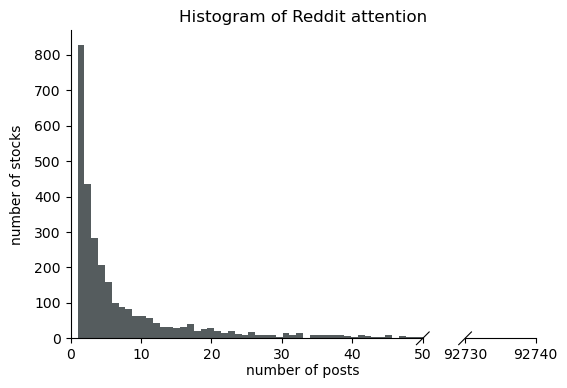

In [460]:
fig = plt.figure(figsize=(6,4))
baxes = brokenaxes(xlims=((0,50),(92730,92740)))
#x = np.linspace(0,1,50)
baxes.hist(attention_bystock[attention_bystock['num_post']<100]['num_post'], bins=100, rwidth=1, color = '#555c5e')
                   #color='#607c8e')
baxes.set_xlabel('number of posts')
baxes.set_ylabel('number of stocks')
baxes.set_title('Histogram of Reddit attention')
plt.show()

In [506]:
for d in [100000, 200, 100, 50, 25, 10, 5, 2]:
    print(len(attention_bystock[attention_bystock['num_post']<d]))

3177
3116
3043
2929
2726
2250
1755
828


In [486]:
attention_byauthor = pd.DataFrame(panel_author.groupby('author').sum())

In [487]:
attention_byauthor

,score,num_comments,num_post
author,,,
--Clintoris--,36,11,1
--Satoshi-Nakamoto--,1,0,1
--Superb,277,30,2
--V0X--,1,0,1
--Warmonger--,2,0,2
...,...,...,...
zzvc8x,1,0,1
zzxNOGOODxzz,2,2,2
zzz1982,1,0,1


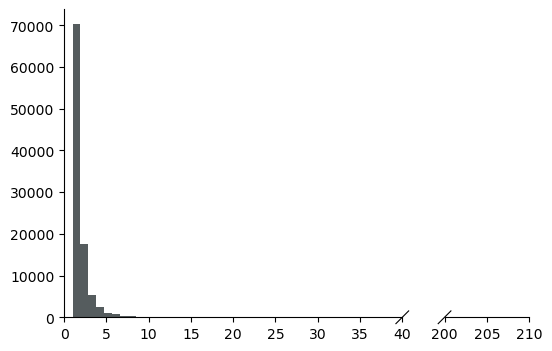

In [503]:
fig = plt.figure(figsize=(6,4))
baxes = brokenaxes(xlims=((0,40),(200,210)))
baxes.hist(attention_byauthor[attention_byauthor['num_post']<100]['num_post'], bins=100, color = '#555c5e')
                   #color='#607c8e')
plt.show()

- Discussion on Reddit are concentrated on a few high-attention stocks
- Half of the stocks were mentioned less than 5 times during the 8-month window


## Todos
before Mar.12th

- Merge the cleaned Reddit data with stock data from CRSP and Compustat
- Present more stock-level summary statistics
- Build weekly portfolios sorted by Reddit attention
- Explore the relationship between stock return and reddit attention
--------------------
after Mar.12th

Extend the analyses in a few ways: 
- X: sentiment, disagreement, influencer (post author)
- Y: retail trades and short interest
- compare Reddit attention with other existing proxies of retail attention (e.g., Google search volume)
- Find ways to causally identify the effect of social media platform (e.g., change of platform layout design, platform outage)

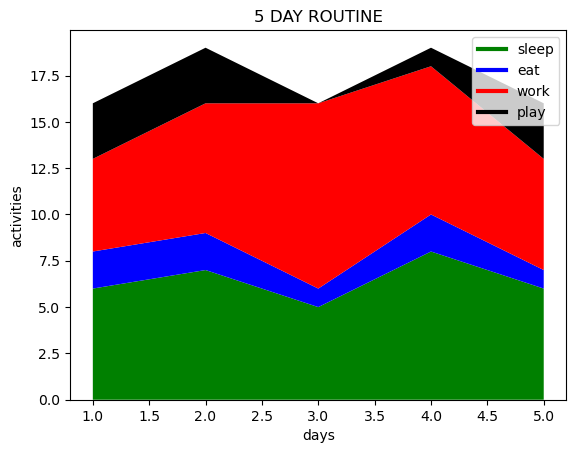

In [470]:
days = [1,2,3,4,5]

sleep = [6,7,5,8,6]
eat =   [2,2,1,2,1]
work =  [5,7,10,8,6]
exercise=  [3,3,0,1,3]


plt.plot([],[],color='green', label='sleep', linewidth=3)
plt.plot([],[],color='blue', label='eat', linewidth=3)
plt.plot([],[],color='red', label='work', linewidth=3)
plt.plot([],[],color='black', label='play', linewidth=3)

plt.stackplot(days, sleep, eat, work, exercise, colors=['green','blue','red','black'])

plt.xlabel('days')
plt.ylabel('activities')
plt.title('5 DAY ROUTINE')
plt.legend()
plt.show()